In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torchmetrics

In [2]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
lr = 1e-3
epochs = 5

root_path = "/Users/asandeistefan/Downloads"

# Data preparation

In [3]:
class BasketballDataset(Dataset):
    def __init__(self, split = 'train'):
        super().__init__()

        filename = "data_train" if split == 'train' else "data_test"
        self.df = pd.read_csv(f"{root_path}/{filename}.csv")

        self.features = ["loc_x", "loc_y"]
        self.label = "shot_made_flag"

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        X = torch.tensor(row[self.features].values, dtype=torch.float32)
        y = torch.tensor(row[self.label], dtype=torch.float32)

        return X, y

    def __len__(self):
        return len(self.df)

In [4]:
dataset_train = BasketballDataset()

dataset_train.df.head()

,loc_x,loc_y,minutes_remaining,shot_distance,shot_made_flag,shot_id
0,0,0,7,0,1,1
1,-3,130,9,13,0,2
2,82,8,7,8,0,3
3,100,101,10,14,1,4
4,0,0,9,0,1,5


In [5]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [6]:
batch = next(iter(dataloader_train))
batch[0].shape

torch.Size([128, 2])

# Model selection

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.linear1 = nn.Linear(2, 4)
        self.linear2 = nn.Linear(4, 4)
        self.linear3 = nn.Linear(4, 1)

        self.actv = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.actv(self.linear1(x))
        x = self.dropout(x)

        x = self.actv(self.linear2(x))
        x = self.dropout(x)

        x = F.sigmoid(self.linear3(x))
        return x

In [8]:
model = MyModel().to(device)
batch_X = batch[0].to(device)

model(batch_X).shape

torch.Size([128, 1])

# Training

In [9]:
accuracy = torchmetrics.Accuracy(task='binary').to(device)
losses = []

critetion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    accuracy.reset()

    for batch in tqdm(dataloader_train):
        X, y = batch[0].to(device), batch[1].to(device).unsqueeze(1)

        # forward pass
        pred = model(X)
        loss = critetion(pred, y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2.5)
        optimizer.step()

        # stats
        accuracy(pred, y)
        losses.append(loss.item())
        running_loss += loss.item()

    print(f"Epoch {epoch}; loss={(running_loss/len(dataloader_train)):.4f}, accuracy={accuracy.compute()*100:.1f}%")

100%|██████████| 196/196 [00:12<00:00, 15.82it/s]


Epoch 0; loss=0.8012, accuracy=51.1%


100%|██████████| 196/196 [00:09<00:00, 19.94it/s]


Epoch 1; loss=0.6907, accuracy=53.6%


100%|██████████| 196/196 [00:10<00:00, 19.41it/s]


Epoch 2; loss=0.6829, accuracy=54.3%


100%|██████████| 196/196 [00:09<00:00, 20.63it/s]


Epoch 3; loss=0.6807, accuracy=54.1%


100%|██████████| 196/196 [00:09<00:00, 20.60it/s]

Epoch 4; loss=0.6800, accuracy=56.0%


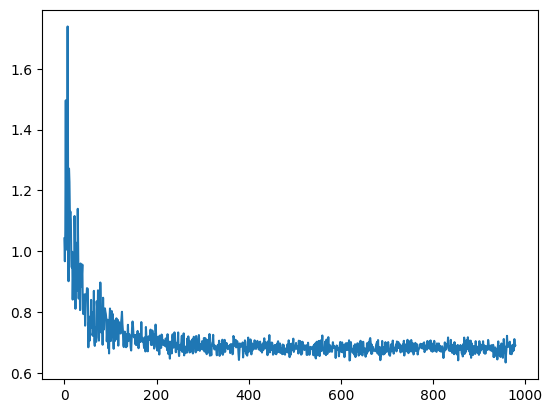

In [11]:
plt.plot(losses)

# Submission

In [12]:
# 1. Save the weights
WEIGHTS_FILE = "submission_dic.pth"
torch.save(model.state_dict(), WEIGHTS_FILE)

# 2. Write out the submission script
SUBMISSION_SCRIPT = Path("submission_model.py")
SUBMISSION_SCRIPT.write_text(
"""
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 4)
        self.linear2 = nn.Linear(4, 4)
        self.linear3 = nn.Linear(4, 1)
        self.actv    = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.actv(self.linear1(x))
        x = self.actv(self.linear2(x))
        return torch.sigmoid(self.linear3(x))
""".lstrip()
)

# 3. Zip them up
ZIP_NAME = "submission.zip"
with zipfile.ZipFile(ZIP_NAME, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(WEIGHTS_FILE)
    z.write(SUBMISSION_SCRIPT)

print(f"Created {ZIP_NAME} containing:")
print(" ", WEIGHTS_FILE, "\n ", SUBMISSION_SCRIPT.name)

Created submission.zip containing:
  submission_dic.pth 
  submission_model.py
